In [2]:
%load_ext autoreload
%autoreload 2

import os

import sys
sys.path.append(os.environ['GORDON_REPO_DIR'] + '/pipeline_scripts')

import utilities2014
reload(utilities2014)
from utilities2014 import *

import time

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram, ward

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filters.rank import gradient

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dm = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=1)
dm._load_image()

texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = len(np.unique(textonmap)) - 1
neighbors = dm.load_pipeline_result('neighbors', 'pkl')
sp_properties = dm.load_pipeline_result('spProps', 'npy')
segmentation_vis = dm.load_pipeline_result('segmentationWithText', 'jpg')

# texture_map = texton_hists[segmentation]
# texture_map[~dm.mask] = np.nan * np.ones((n_texton,))
# dm.save_pipeline_result(texture_map, 'textureMap', 'npy')
texture_map = dm.load_pipeline_result('textureMap', 'npy')

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [7]:
dedge_vectors = dm.load_pipeline_result('edgeVectors', 'pkl')
dedge_neighbors = dm.load_pipeline_result('dedgeNeighbors', 'pkl')

In [8]:
edge_coords = dict(dm.load_pipeline_result('edgeCoords', 'pkl'))
all_edges = edge_coords.keys()
all_dedges = set(chain(*[[(i,j),(j,i)] for i,j in all_edges]))

edge_neighbors = dm.load_pipeline_result('edgeNeighbors', 'pkl')

In [9]:
models = dm.load_pipeline_result('boundaryModels', 'pkl')

In [10]:
thetas = np.linspace(-np.pi/4, np.pi/4, 9)
n_theta = len(thetas)
Rs = [np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) for theta in thetas]

In [55]:
for i, lm_ind in enumerate([0,4,24,2,17]):
    
# i = 3
# lm_ind = 2

    print 'landmark', i

    lm_dedges = [de for de in models[lm_ind][0] if frozenset(de) in edge_coords]

    lm_edge_points = np.array([edge_coords[frozenset(de)].mean(axis=0) for de in lm_dedges], dtype=np.int)
    lm_edge_vectors = np.array([dedge_vectors[de]  for de in lm_dedges])
    lm_edge_int_textures = np.array([texton_hists[de[1]]  for de in lm_dedges])
    lm_edge_ext_textures = np.array([texton_hists[de[0]]  for de in lm_dedges])

    xmin, ymin = lm_edge_points.min(axis=0).astype(np.int)
    xmax, ymax = lm_edge_points.max(axis=0).astype(np.int)
    centroid_global = lm_edge_points.mean(axis=0).astype(np.int)

    lm_points_local = lm_edge_points - [xmin, ymin]
    centroid_local = centroid_global - [xmin, ymin]

    lm_box_shape = [xmax - xmin + 1, ymax - ymin + 1]

    bbox_dims = np.array([lm_box_shape[0], lm_box_shape[1], xmin, ymin, xmax, ymax, 
                 centroid_global[0], centroid_global[1], centroid_local[0], centroid_local[1]])

    np.save('/home/yuncong/csd395/lm_bbox_dims_%d.npy'%i, bbox_dims.astype(np.int))

    lm_edges_tuple = np.c_[lm_edge_points, lm_points_local, lm_edge_vectors]
    np.save('/home/yuncong/csd395/lm_edge_points_%d.npy'%i, lm_edges_tuple)

    lm_edge_textures = np.c_[lm_edge_int_textures, lm_edge_ext_textures]
    np.save('/home/yuncong/csd395/lm_edge_textures_%d.npy'%i, lm_edge_textures)

    lm_texture_template = texture_map[ymin:ymax+1, xmin:xmax+1]
    np.save('/home/yuncong/csd395/lm_texture_template_%d.npy'%i, lm_texture_template)

    lm_points_centered = lm_edge_points - centroid_global

    for theta_i in range(n_theta):
    #theta_i = 0

        print 'theta', theta_i

        lm_pts_rotated = np.dot(Rs[theta_i], lm_points_centered.T).astype(np.int).T
        lm_pts_rotated_local = lm_pts_rotated - lm_pts_rotated.min(axis=0)
        centroid_local_rotated = - lm_pts_rotated.min(axis=0)
        lm_pts_rotated_global = lm_pts_rotated + centroid_global

        rotated_lm_box_shape = lm_pts_rotated_local.max(axis=0) + [1,1]

        rotated_texTemplate = np.nan * np.ones((rotated_lm_box_shape[1], rotated_lm_box_shape[0], n_texton))

        ys, xs = np.mgrid[:rotated_lm_box_shape[1], :rotated_lm_box_shape[0]]
        a = np.dot(np.linalg.inv(Rs[theta_i]), (np.c_[xs.flat, ys.flat] - centroid_local_rotated).T).T

        xss = (a[:,0] + centroid_local[0]).astype(np.int)
        yss = (a[:,1] + centroid_local[1]).astype(np.int)
        valid = (yss < lm_texture_template.shape[0]) & (yss >= 0) & (xss < lm_texture_template.shape[1]) & (xss >= 0)
        rotated_texTemplate[ys.flat[valid], xs.flat[valid]] = lm_texture_template[yss[valid], xss[valid]]

        np.save('/home/yuncong/csd395/lm_texture_template_%d_orientation%d.npy'%(i, theta_i), rotated_texTemplate)


        bbox_dims_rotated = np.array([rotated_lm_box_shape[0], rotated_lm_box_shape[1],
                            np.nan, np.nan, np.nan, np.nan,
                             np.nan, np.nan, centroid_local_rotated[0], centroid_local_rotated[1]])

        np.save('/home/yuncong/csd395/lm_bbox_dims_%d_orientation%d.npy'%(i, theta_i), bbox_dims_rotated.astype(np.int))

        lm_edge_vectors_rotated = np.dot(Rs[theta_i], lm_edge_vectors.T).T

        edge_tuple_rotated = np.c_[lm_pts_rotated_global, lm_pts_rotated_local, lm_edge_vectors_rotated]
        np.save('/home/yuncong/csd395/lm_edge_points_%d_orientation%d.npy'%(i, theta_i), edge_tuple_rotated)


landmark 0
theta 0
theta 1
theta 2
theta 3
theta 4
theta 5
theta 6
theta 7
theta 8
landmark 1
theta 0
theta 1
theta 2
theta 3
theta 4
theta 5
theta 6
theta 7
theta 8
landmark 2
theta 0
theta 1
theta 2
theta 3
theta 4
theta 5
theta 6
theta 7
theta 8
landmark 3
theta 0
theta 1
theta 2
theta 3
theta 4
theta 5
theta 6
theta 7
theta 8
landmark 4
theta 0
theta 1
theta 2
theta 3
theta 4
theta 5
theta 6
theta 7
theta 8


In [56]:
# # n_existing_lm = i + 1
# n_existing_lm = 5
# i = n_existing_lm

In [57]:
for i in range(5):

    print 'landmark', i

    lm_edge_points = np.array([[4770,4905,4978,5047,5098,5151,5173,5205,5167,5097],
                               [1078,1111,1143,1185,1225,1290,1330,1435,1501,1555]], np.int).T


    D = cdist(lm_edge_points, lm_edge_points)
    pts_sorted = D.argsort(axis=1)[:,:3]

    gradient_dirs = np.empty((lm_edge_points.shape[0], 2))
    for pi, neighborhood in enumerate(pts_sorted):
        X = lm_edge_points[neighborhood]
        c = X.mean(axis=0)
        Xc = X - c
        U,S,V = np.linalg.svd(np.dot(Xc.T, Xc))
        tangent_dir = U[:,0]
        gradient_dirs[pi] = np.array([tangent_dir[1], -tangent_dir[0]])
        if np.dot(gradient_dirs[i], [1,0]) < 0:
            gradient_dirs[pi] = -gradient_dirs[pi]

    lm_edge_vectors = gradient_dirs

    texture_sample_radius = 5
    int_rs = np.arange(-texture_sample_radius, 0)
    ext_rs = np.arange(1, texture_sample_radius+1)

    int_texture_sample_xs = (lm_edge_points[:,0][:,None] + np.outer(gradient_dirs[:,0], int_rs)).astype(np.int)
    int_texture_sample_ys = (lm_edge_points[:,1][:,None] + np.outer(gradient_dirs[:,1], int_rs)).astype(np.int)
    lm_edge_int_textures = texture_map[int_texture_sample_ys, int_texture_sample_xs].mean(axis=1)


    ext_texture_sample_xs = (lm_edge_points[:,0][:,None] + np.outer(gradient_dirs[:,0], ext_rs)).astype(np.int)
    ext_texture_sample_ys = (lm_edge_points[:,1][:,None] + np.outer(gradient_dirs[:,1], ext_rs)).astype(np.int)
    lm_edge_ext_textures = texture_map[ext_texture_sample_ys, ext_texture_sample_xs].mean(axis=1)


    xmin, ymin = lm_edge_points.min(axis=0).astype(np.int)
    xmax, ymax = lm_edge_points.max(axis=0).astype(np.int)
    centroid_global = lm_edge_points.mean(axis=0).astype(np.int)

    lm_points_local = lm_edge_points - [xmin, ymin]
    centroid_local = centroid_global - [xmin, ymin]

    lm_box_shape = [xmax - xmin + 1, ymax - ymin + 1]

    bbox_dims = np.array([lm_box_shape[0], lm_box_shape[1], xmin, ymin, xmax, ymax, 
                 centroid_global[0], centroid_global[1], centroid_local[0], centroid_local[1]])

    np.save('/home/yuncong/csd395/lm_bbox_dims_%d.npy'%i, bbox_dims.astype(np.int))

    lm_edges_tuple = np.c_[lm_edge_points, lm_points_local, lm_edge_vectors]
    np.save('/home/yuncong/csd395/lm_edge_points_%d.npy'%i, lm_edges_tuple)

    lm_edge_textures = np.c_[lm_edge_int_textures, lm_edge_ext_textures]
    np.save('/home/yuncong/csd395/lm_edge_textures_%d.npy'%i, lm_edge_textures)

    lm_texture_template = texture_map[ymin:ymax+1, xmin:xmax+1]
    np.save('/home/yuncong/csd395/lm_texture_template_%d.npy'%i, lm_texture_template)

    lm_points_centered = lm_edge_points - centroid_global

    for theta_i in range(n_theta):
    #theta_i = 0

        print 'theta', theta_i

        lm_pts_rotated = np.dot(Rs[theta_i], lm_points_centered.T).astype(np.int).T
        lm_pts_rotated_local = lm_pts_rotated - lm_pts_rotated.min(axis=0)
        centroid_local_rotated = - lm_pts_rotated.min(axis=0)
        lm_pts_rotated_global = lm_pts_rotated + centroid_global


        rotated_lm_box_shape = lm_pts_rotated_local.max(axis=0) + [1,1]

        rotated_texTemplate = np.nan * np.ones((rotated_lm_box_shape[1], rotated_lm_box_shape[0], n_texton))

        ys, xs = np.mgrid[:rotated_lm_box_shape[1], :rotated_lm_box_shape[0]]
        a = np.dot(np.linalg.inv(Rs[theta_i]), (np.c_[xs.flat, ys.flat] - centroid_local_rotated).T).T

        xss = (a[:,0] + centroid_local[0]).astype(np.int)
        yss = (a[:,1] + centroid_local[1]).astype(np.int)
        valid = (yss < lm_texture_template.shape[0]) & (yss >= 0) & (xss < lm_texture_template.shape[1]) & (xss >= 0)
        rotated_texTemplate[ys.flat[valid], xs.flat[valid]] = lm_texture_template[yss[valid], xss[valid]]

        np.save('/home/yuncong/csd395/lm_texture_template_%d_orientation%d.npy'%(i, theta_i), rotated_texTemplate)


        bbox_dims_rotated = np.array([rotated_lm_box_shape[0], rotated_lm_box_shape[1],
                            np.nan, np.nan, np.nan, np.nan,
                             np.nan, np.nan, centroid_local_rotated[0], centroid_local_rotated[1]])

        np.save('/home/yuncong/csd395/lm_bbox_dims_%d_orientation%d.npy'%(i, theta_i), bbox_dims_rotated.astype(np.int))

        lm_edge_vectors_rotated = np.dot(Rs[theta_i], lm_edge_vectors.T).T

        edge_tuple_rotated = np.c_[lm_pts_rotated_global, lm_pts_rotated_local, lm_edge_vectors_rotated]
        np.save('/home/yuncong/csd395/lm_edge_points_%d_orientation%d.npy'%(i, theta_i), edge_tuple_rotated)


landmark 5
theta 0
theta 1
theta 2
theta 3
theta 4
theta 5
theta 6
theta 7
theta 8


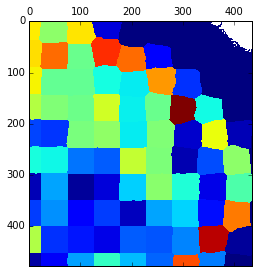

In [58]:
t = np.load('/home/yuncong/csd395/lm_texture_template_%d_orientation%d.npy'%(5, 4))
plt.matshow(t[:,:,0])

In [7]:
lm_edge_points = np.load('/home/yuncong/csd395/lm_edge_points_%d_orientation%d.npy'%(5, 4))[:, :2].astype(np.int)

ys = lm_edge_points[:,1]
xs = lm_edge_points[:,0]

bg_ubyte = img_as_ubyte(dm.image_rgb)

overlay = np.zeros_like(dm.image, np.bool)
overlay[ys, xs] = 1
overlay = binary_dilation(overlay, disk(5))
bg_ubyte[overlay] = [0,255,0]

display(bg_ubyte)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg